<a href="https://colab.research.google.com/github/snsamarasekara/healthcare-claims/blob/main/Healthcare_Claims_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import pickle
import warnings

In [28]:
# import datasets
beneficiary = pd.read_csv('/content/Train_Beneficiarydata-1542865627584.csv')
inpatient = pd.read_csv('/content/Train_Inpatientdata-1542865627584.csv')
outpatient = pd.read_csv('/content/Train_Outpatientdata-1542865627584.csv')
fraud = pd.read_csv('/content/Train-1542865627584.csv')

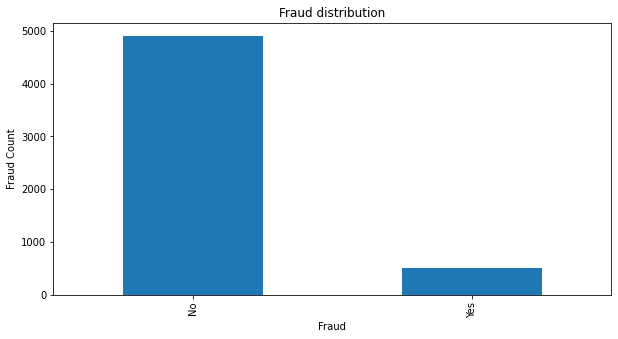

In [29]:
plt.title("Fraud distribution")
fraud.groupby( ["PotentialFraud"] ).Provider.count().plot(kind = "bar", figsize = (10,5))
plt.xlabel('Fraud')
plt.ylabel('Fraud Count')
plt.show()


In [30]:
# to check if there's any discrepencies in data
flag=True
df=pd.DataFrame()
df=beneficiary[beneficiary['Gender']>2]
df=beneficiary[beneficiary['Gender']<1]
if df.shape[0]!=0:
    print("There's an error in gender column",df)
    flag=False

df=pd.DataFrame()
df=beneficiary[beneficiary['State']>54]
df=beneficiary[beneficiary['State']<1]
if df.shape[0]!=0:
    print("There's an error in states column",df)
    flag=False

df=pd.DataFrame()
df=beneficiary[beneficiary['County']>999]
df=beneficiary[beneficiary['County']<0]
if df.shape[0]!=0:
    print("There's an error in Countries column \n",df)
    flag=False

df=pd.DataFrame()
df=inpatient[inpatient['ClaimID'].duplicated()]
if df.shape[0]!=0:
    print("There's an error in ClaimID or multiple people have same ID: \n",df)
    flag=False
     

In [31]:
if flag:
    print("No discrepancies found")

No discrepancies found


In [32]:
overpayment = pd.DataFrame([beneficiary.BeneID, beneficiary.IPAnnualReimbursementAmt, beneficiary.IPAnnualDeductibleAmt, beneficiary.OPAnnualReimbursementAmt, beneficiary.OPAnnualDeductibleAmt]).transpose()
     
overpayment.head()

,BeneID,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,36000,3204,60,70
1,BENE11002,0,0,30,50
2,BENE11003,0,0,90,40
3,BENE11004,0,0,1810,760
4,BENE11005,0,0,1790,1200


In [33]:
overpayment['Bill'] = overpayment['IPAnnualReimbursementAmt'] + overpayment['OPAnnualReimbursementAmt']
overpayment['Reimbursement'] = overpayment['IPAnnualDeductibleAmt'] + overpayment['OPAnnualDeductibleAmt']
     

In [34]:
overpayment.drop(overpayment.columns[[1,2,3,4]], axis=1, inplace=True)
overpayment.head()

,BeneID,Bill,Reimbursement
0,BENE11001,36060,3274
1,BENE11002,30,50
2,BENE11003,90,40
3,BENE11004,1810,760
4,BENE11005,1790,1200


In [35]:
overpayment['Overpayment'] = np.where(overpayment['Bill']>overpayment['Reimbursement'],True,False)
overpayment.head()

,BeneID,Bill,Reimbursement,Overpayment
0,BENE11001,36060,3274,True
1,BENE11002,30,50,False
2,BENE11003,90,40,True
3,BENE11004,1810,760,True
4,BENE11005,1790,1200,True


In [36]:
In_Provider=pd.DataFrame([inpatient['Provider'].value_counts().index,inpatient['Provider'].value_counts()]).transpose().rename({0:'Provider',1:'Inpatient_Claim_Number'},axis=1)
Out_Provider=pd.DataFrame([outpatient['Provider'].value_counts().index,outpatient['Provider'].value_counts()]).transpose().rename({0:'Provider',1:'Outpatient_Claim_Number'},axis=1)
provider_claimnumber=pd.merge(In_Provider,Out_Provider,on='Provider',how='outer')
inreimburse_by_provider=inpatient.groupby('Provider')['InscClaimAmtReimbursed'].sum()
inreimburse_temp1=pd.DataFrame([inreimburse_by_provider.index,inreimburse_by_provider])
inreimburse_temp2=inreimburse_temp1.transpose()
In_Provider_Claim=inreimburse_temp2.rename({0:'Provider',1:'Inpatient_Claim_Amount'},axis=1)
outreimburse_by_provider=outpatient.groupby('Provider')['InscClaimAmtReimbursed'].sum()
outreimburse_temp=pd.DataFrame([outreimburse_by_provider.index,outreimburse_by_provider]).transpose()
Out_Provider_Claim=outreimburse_temp.rename({0:'Provider',1:'Outpatient_Claim_Amount'},axis=1)
provider_claimamount=pd.merge(In_Provider_Claim,Out_Provider_Claim,on='Provider',how='outer')
provider_list1=pd.merge(fraud,provider_claimnumber,on='Provider',how='outer')
provider_list2=pd.merge(provider_list1,provider_claimamount,on='Provider',how='outer')
     

In [37]:
provider_list2.head()
     

,Provider,PotentialFraud,Inpatient_Claim_Number,Outpatient_Claim_Number,Inpatient_Claim_Amount,Outpatient_Claim_Amount
0,PRV51001,No,5,20,97000,7640
1,PRV51003,Yes,62,70,573000,32670
2,PRV51004,No,NaN,149,NaN,52170
3,PRV51005,Yes,NaN,1165,NaN,280910
4,PRV51007,No,3,69,19000,14710


In [38]:
provider_clean=provider_list2.fillna(0)
y = provider_clean['PotentialFraud'].values
X = provider_clean.drop(['PotentialFraud','Provider'], axis=1).values
     

In [39]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, random_state=21, stratify=y)
param_grid = {'n_neighbors': np.arange(1, 15)}
knn = KNeighborsClassifier()
knn_cv1 = GridSearchCV(knn, param_grid, cv=5)
knn_cv1.fit(X_train1, y_train1)
print('Accuracy : {}%'.format(knn_cv1.best_score_*100))

Accuracy : 93.13429974590714%


In [40]:
#from sklearn.linear_model import LogisticRegression
#logisticreg = LogisticRegression(tol=1e-7, penalty='l2', C=0.0005)
#logisticreg.fit(X_train1, y_train1)
#Ylog = logisticreg.predict(X_test1)
#print(logisticreg.score(X_test1, y_test1)) 

In [41]:
# 100% accuracy random forest
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(random_state=42,n_estimators=100)
random_forest.fit(X_train1, y_train1)
Yrandforest = random_forest.predict(X_test1)

     

print(random_forest.score(X_test1, y_test1))

0.922365988909427


In [42]:
filename = open('knn_cv1.pkl','wb')
pickle.dump(knn_cv1,filename)

In [44]:
provider_clean.head()
     

,Provider,PotentialFraud,Inpatient_Claim_Number,Outpatient_Claim_Number,Inpatient_Claim_Amount,Outpatient_Claim_Amount
0,PRV51001,No,5,20,97000,7640
1,PRV51003,Yes,62,70,573000,32670
2,PRV51004,No,0,149,0,52170
3,PRV51005,Yes,0,1165,0,280910
4,PRV51007,No,3,69,19000,14710


In [45]:
provider_clean['Mode_of_Payment'] = np.where(provider_clean['Inpatient_Claim_Number']<3,'Check','EFT')

In [46]:
y = provider_clean['Mode_of_Payment'].values
X = provider_clean.drop(['PotentialFraud','Provider','Mode_of_Payment'], axis=1).values
     

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21, stratify=y)
param_grid = {'n_neighbors': np.arange(1, 15)}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv=5)
knn_cv.fit(X_train, y_train)
print('Accuracy : {}%'.format(knn_cv.best_score_*100))

Accuracy : 96.83115896313389%


In [47]:
finalfile = open('knn_cv.pkl','wb')
pickle.dump(knn_cv, finalfile)
     

In [48]:
!pip install anvil-uplink
import anvil.server
anvil.server.connect('CBIFDCYQ5Y2KPITWG74YBHXL-EPCXKWQ2K652DG45')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [49]:
import pickle
loaded_model1 = pickle.load(open('knn_cv1.pkl', 'rb'))

In [50]:
@anvil.server.callable
def task_3(t,t1,t2,t3):
  inclaimnumber=int(t)
  outclaimnumber=int(t1)
  inclaimamount=int(t2)
  outclaimamount=int(t3)
  temp=[inclaimnumber,outclaimnumber,inclaimamount,outclaimamount]
  temp2= 'Probability of No : '+str(loaded_model1.predict_proba([temp])[0][0])+'\nProbability of Yes : '+str(loaded_model1.predict_proba([temp])[0][1])
  return(("The model prediction for potential Appeals & Grievances (A&G) inflow and processing : ",loaded_model1.predict([temp])[0],temp2))

In [51]:
import anvil.server
anvil.server.connect('CBIFDCYQ5Y2KPITWG74YBHXL-EPCXKWQ2K652DG45')
loaded_model2 = pickle.load(open('knn_cv.pkl', 'rb'))

In [52]:
@anvil.server.callable
def task_4(t,t1,t2,t3):
  inclaimnumber=int(t)
  outclaimnumber=int(t1)
  inclaimamount=int(t2)
  outclaimamount=int(t3)
  temp=[inclaimnumber,outclaimnumber,inclaimamount,outclaimamount]
  print(loaded_model2.predict_proba([temp]))
  temp2= 'Probability of Check Payment : '+str(loaded_model2.predict_proba([temp])[0][0])+'\nProbability of EFT : '+str(loaded_model2.predict_proba([temp])[0][1])
  return('Most Customers with payment information similar to this use : ',loaded_model2.predict([temp])[0],temp2)
     